In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, Simulation
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

from relaxation.estimators import relaxation_finder_collision
import logging
import sys, os

matplotlib.rcParams["figure.dpi"] = 150
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

/home/ashmat/cluster/LJ-magnetic/simulator/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def standartize(arr):
    return (arr - np.mean(arr))/np.std(arr)

In [3]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name.in_(["ER 3"] ))
                 .order_by(Simulation.start_time)).all()[:]
query = [x[0] for x in query]
print(len(query))

1


In [5]:
%%time
item = client.query_simulation(id=query[0], full_load=False)
item.load_history(keys=["time","L"])

CPU times: user 257 ms, sys: 1.21 s, total: 1.46 s
Wall time: 11.8 s


In [23]:
def f(sid):
    item = client.query_simulation(id=sid, full_load=False)
    item.load_history(keys=["time","L"])

    return item.history["time"], item.history["L"][:,2,:].sum(axis=-1)

In [7]:
if "pool" in dir():
    pool.close()
    print("closed")
pool = Pool(cpu_count()-3, maxtasksperchild=1); pool

In [24]:
# result = list(tqdm(pool.imap(f, query[:]), total=len(query)))
result = [f(x) for x in tqdm(query[:])]

100%|██████████| 90/90 [18:18<00:00, 12.21s/it]


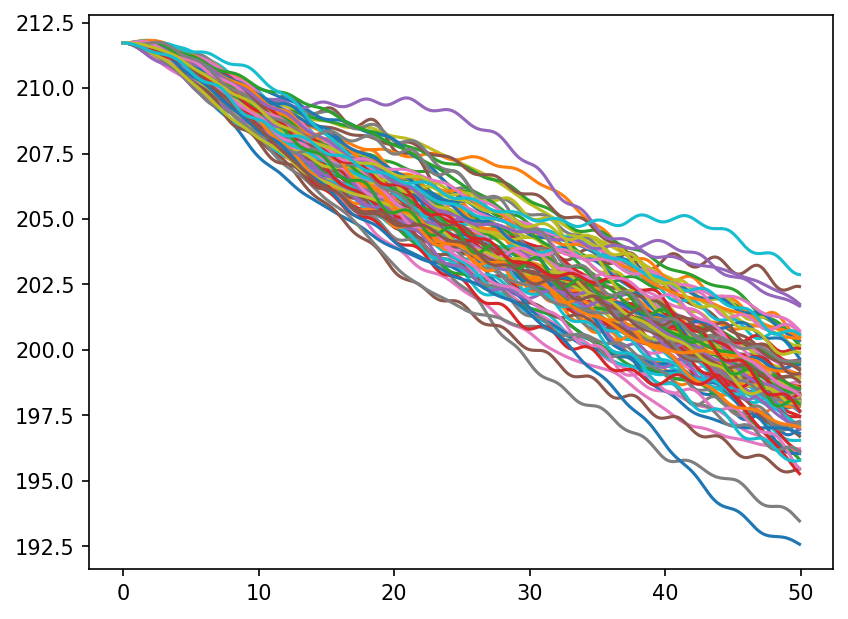

In [29]:
for t, l in result:
    plt.plot(t[:500], l[:500])
#     plt.plot(t, l)

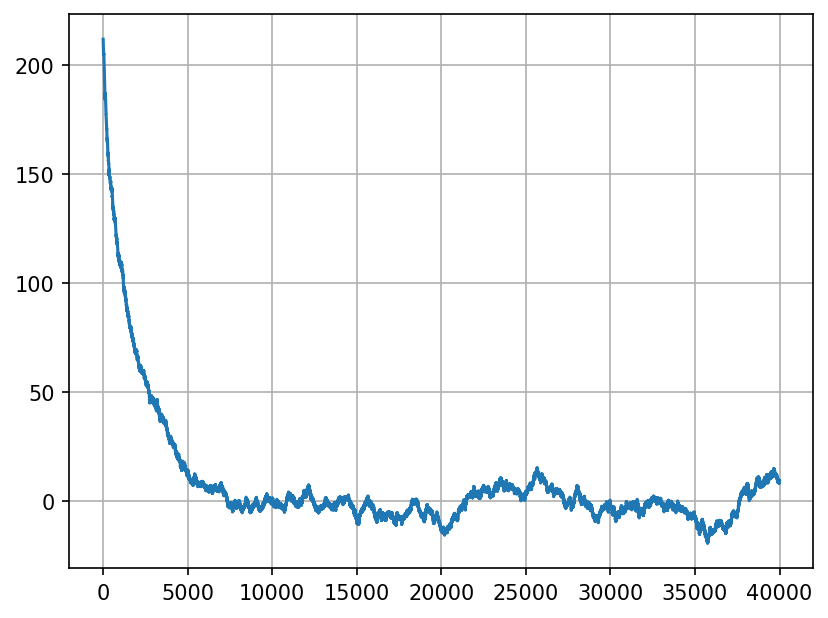

In [14]:
plt.plot(t,l)
plt.grid()

In [15]:
item.finish_time - item.start_time

datetime.timedelta(days=3, seconds=42477, microseconds=158256)

In [16]:
item.particles

273

In [8]:
df = pd.DataFrame(result)
gb = df.groupby("N")

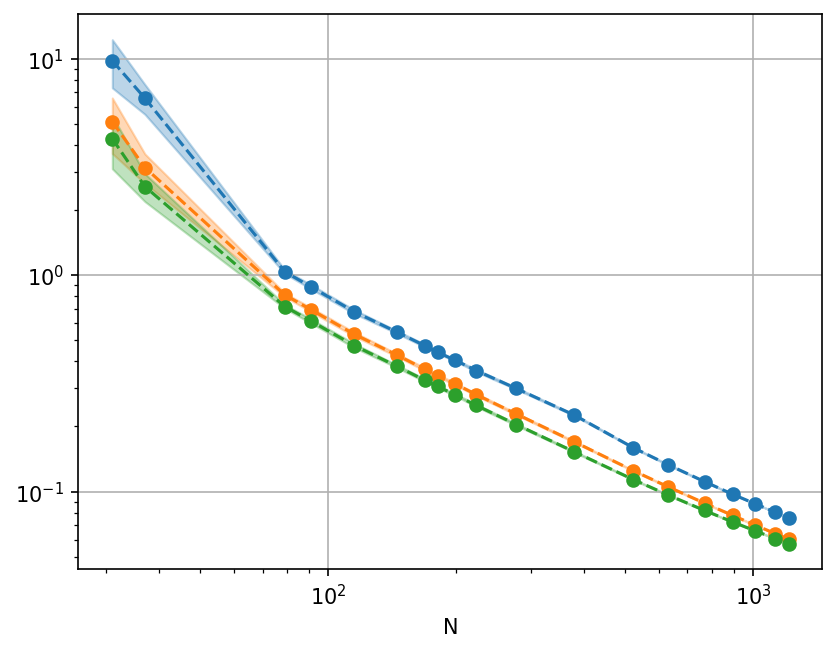

In [10]:
def plot_mean_std(df_mean, df_std, color, label):
    df_mean.plot(color=color, label=label, ls="--", marker="o")
    plt.fill_between(df_mean.index, 
                     (df_mean + df_std).values, 
                     (df_mean - df_std).values, color=color, alpha=0.3)
    
for col, c in zip(gb.mean().columns, colors):
    plot_mean_std(gb.mean()[col], gb.std()[col], c, col)
plt.yscale("log")
plt.xscale("log")

plt.grid()

In [42]:
# df = df.set_index("N").sort_index()
# df.plot()

In [12]:
df[["x","y_beta","y_omega"]].to_csv("beta-omega-plot-data-ensemble-5.1.csv", index=False)

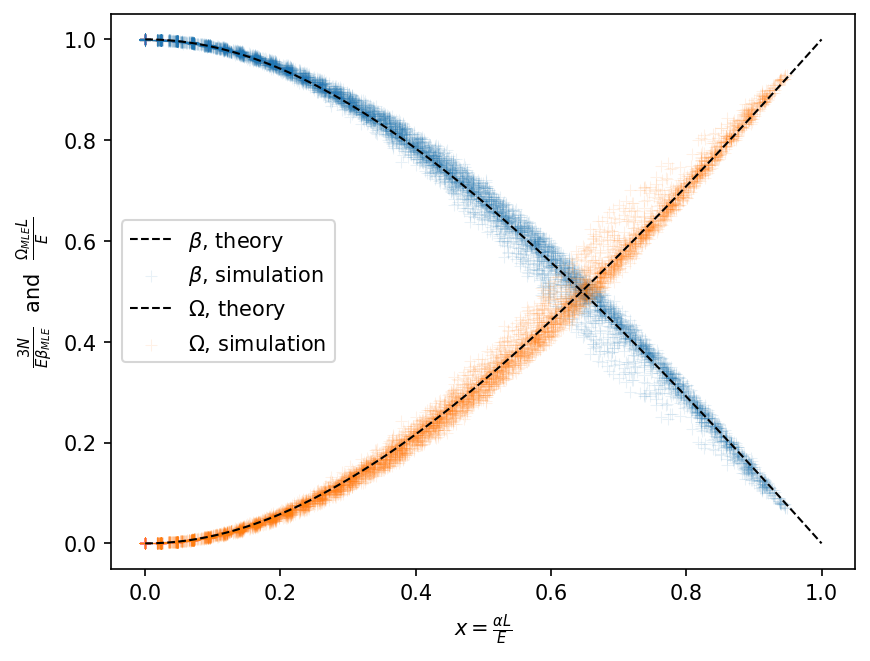

In [13]:
xs = np.linspace(0,1,100)
alpha=0.1
plt.plot(xs, f_beta(xs), "k--", lw=1, label=r"$\beta$, theory")
plt.scatter(df["x"], df["y_beta"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\beta$, simulation")

plt.plot(xs, f_omega(xs), "k--", lw=1, label="$\Omega$, theory")
plt.scatter(df["x"], df["y_omega"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\Omega$, simulation")


plt.xlabel(r"$x=\frac{\alpha L}{E}$")

plt.ylabel(r"$\frac{3 N}{ E \beta_{MLE} }$  and  $\frac{\Omega_{MLE} L}{E}$")
plt.legend()

In [14]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name=='Ensemble 4')
                 .where(Simulation.Bz == 0)
                 .order_by(Simulation.start_time)).all()[:]
query = [x[0] for x in query]
print(len(query))

1001


In [15]:
np.random.shuffle(query)

In [17]:
sims = []
for sid in tqdm(query[:200]):
    sims.append(
        SimulatorMagnetic(id=sid)
    )

100%|██████████| 200/200 [03:32<00:00,  1.06s/it]


In [18]:
from relaxation.estimators import RelaxationFinder

In [ ]:
RelaxationFinder(sim, tmax=50)

In [ ]:
_74.summarize()

In [20]:
data = []
rs = []
vs = []
for sim in tqdm(sims):
    start = np.searchsorted(sim.get_history()["time"], 40)
    rs.append(sim.get_history()["rs"][start:].transpose(0,2,1).reshape(-1,3))
    vs.append(sim.get_history()["vs"][start:].transpose(0,2,1).reshape(-1,3))
rs = np.concatenate(rs).T
vs = np.concatenate(vs).T

100%|██████████| 200/200 [00:06<00:00, 33.08it/s]


In [21]:
omega_MLE = np.mean(rs[0]*vs[1]-rs[1]*vs[0])/np.mean(rs[0]**2+rs[1]**2)
beta_MLE  = (1/3 * np.mean( (vs[0]+omega_MLE * rs[1])**2 + (vs[1]-omega_MLE * rs[0])**2 + (vs[2])**2) )**-1

In [22]:
omega_MLE, beta_MLE

(0.7211721, 5.182699145361456)

In [23]:
residue = beta_MLE**0.5 * np.array([
    vs[0] + omega_MLE * rs[1],
    vs[1] - omega_MLE * rs[0],
    vs[2]
])

NormaltestResult(statistic=654.0693174267558, pvalue=9.346571436511023e-143)

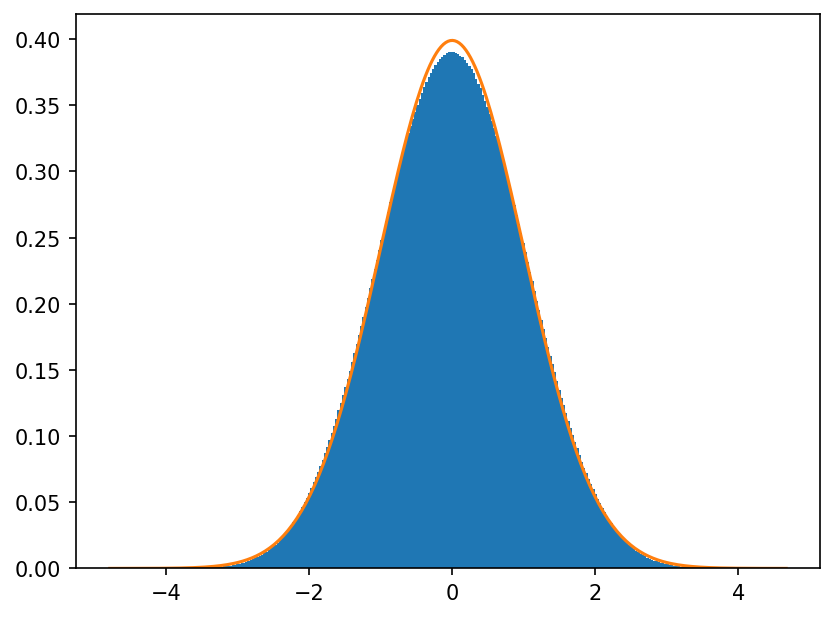

In [24]:
points = standartize(vs[0])
_,xs,_ = plt.hist(points, bins=300, density=1)
plt.plot(xs, norm.pdf(xs, loc=0, scale=1))
normaltest(residue[0])

In [ ]:
sp=100
plot_data = (
    [standartize(vs[0]), standartize(vs[2]), standartize(rs[0]), standartize(rs[2]), residue[0], residue[1], residue[2]],
    ["$v_x$", "$v_z$", "$r_x$", "$r_z$", "residue${}_x$", "residue${}_y$", "residue${}_z$"]
)
# plot_data = (
#     [standartize(vs[0]), standartize(vs[2])],
#     ["$v_x$", "$v_z$"]
# )
n_ = len(plot_data[0])
i_ = 1
plt.figure(figsize=(8,3 * n_))
for points, title in zip(*plot_data): 
    ((osm, osr), (slope, intercept, _r)) = probplot(points, dist="norm",)
    
    plt.subplot(n_, 2, i_);i_+=1
    plt.scatter(osm[::sp], osr[::sp], s=1)
    plt.plot(osm[::sp], osm[::sp] * slope + intercept, ls="--", c="k", lw=0.51)
    plt.title(title+",  "+f"Q-Q plot, slope={slope:0.3f} r={_r:0.3f}");
        
    plt.subplot(n_, 2, i_);i_+=1
    plt.title("diff w.r.t. slope")
    plt.scatter(osm[::sp], osr[::sp]-(osm[::sp] * slope + intercept), s=1)
    plt.grid()

plt.subplots_adjust(bottom=0, right=1, top=1)